In [6]:
suppressMessages(library('ggpubr'))
suppressMessages(library('ggdendro'))
suppressMessages(library('dplyr'))
suppressMessages(library(ggplot2))

In [13]:
# Continuous
contrasts.df <- read.table("data/clustering/full_na_dataset/contrasts_qvars.tsv", sep="\t", header=T)
contrasts.df$cluster <- factor(contrasts.df$fna3_cluster_n, levels=c("Low","Intermediate","High"), ordered=T)

# Fisher Exact
contrasts.fe.df <- read.table("data/clustering/full_na_dataset/contrasts_fe.tsv", sep="\t", header=T)
contrasts.fe.df$odds_r <- -log10(contrasts.fe.df$odds_r)
contrasts.fe.df <- contrasts.fe.df %>% mutate_all(function(x) ifelse(is.infinite(x), 0, x))
contrasts.fe.df$cluster <- factor(contrasts.fe.df$fna3_cluster_n, levels=c("Low","Intermediate","High"), ordered=T)

In [14]:
plotEnrichment <- function(contrasts.df, pval.thresh=0.1, filter=NULL, palette='RdBu', h=13, w=15, s_color='black', fix_id=T){
    
    contrasts.df$sig <- contrasts.df$fdr_bh < pval.thresh
    contrasts.df$logq <- -log10(contrasts.df$fdr_bh)
    
    ### Order axis by dendrogram
    # Load data
    X <- contrasts.df[,c('X','cluster','statistic')]
    X <- reshape(X[,c('X','cluster','statistic')], timevar='cluster', idvar='X', direction='wide',)
    rownames(X) <- X$X
    X$X <- NULL

    X[is.na(X)] <- 0

    # Build the dendrogram
    dend <- as.dendrogram(hclust(d = dist(x = X)))
    dendro.plot <- ggdendrogram(dend,rotate = TRUE)

    # Use dendrogram order to order colomn
    order <- order.dendrogram(dend) # dendrogram order
    contrasts.df$X <- factor(x = contrasts.df$X, levels = unique(contrasts.df$X)[order], ordered = TRUE)

    ### Balloonplot
    options(repr.plot.width=w, repr.plot.height=h)

    p <- ggballoonplot(
        contrasts.df,
        x="cluster",
        y="X",
        fill = "statistic",
        size="logq",
        color=ifelse(contrasts.df$sig==T, s_color, "lightgrey")
        ) +
        scale_fill_distiller(palette=palette, limit = max(abs(contrasts.df$statistic)) * c(-1, 1))+
        labs(x="", y="", fill="Enrichment", size="-log10 Adj. P-val") + theme_linedraw() +
        theme(axis.text.x=element_text(angle=0))

    return(p)
}

plotFisherExactEnrichment <- function(contrasts.df, pval.thresh=0.1, filter=NULL, palette='Blues', h=13, w=15, s_color='black', fix_id=T){
     
    contrasts.df$sig <- contrasts.df$pval_adj < pval.thresh
    contrasts.df$logq <- -log10(contrasts.df$pval_adj)
    
    # Remove non-significants
    contrasts.df <- contrasts.df[contrasts.df$feat %in% contrasts.df[contrasts.df$sig,]$feat,]

    
    ### Order axis by dendrogram
    # Load data
    X <- contrasts.df[,c('feat','cluster','odds_r')]
    X <- reshape(X[,c('feat','cluster','odds_r')], timevar='cluster', idvar='feat', direction='wide',)
    rownames(X) <- X$feat
    X$feat <- NULL

    X[is.na(X)] <- 0

    # Build the dendrogram
    dend <- as.dendrogram(hclust(d = dist(x = X)))
    dendro.plot <- ggdendrogram(dend,rotate = TRUE)

    # Use dendrogram order to order colomn
    order <- order.dendrogram(dend) # dendrogram order
    contrasts.df$feat <- factor(x = contrasts.df$feat, levels = unique(contrasts.df$feat)[order], ordered = TRUE)

    ### Balloonplot
    options(repr.plot.width=w, repr.plot.height=h)

    p <- ggballoonplot(
        contrasts.df,
        x="cluster",
        y="feat",
        fill = "odds_r",
        size="logq",
        color=ifelse(contrasts.df$sig==T, s_color, "lightgrey")
        ) +
        scale_fill_distiller(palette=palette, limit = max(abs(contrasts.df$odds_r)) * c(0, 1))+
        labs(x="", y="", fill="log Odds Ratio", size="-log10 Adj. P-val") + theme_linedraw() +
        theme(axis.text.x=element_text(angle=0))

    return(p)
}

null device 
          1

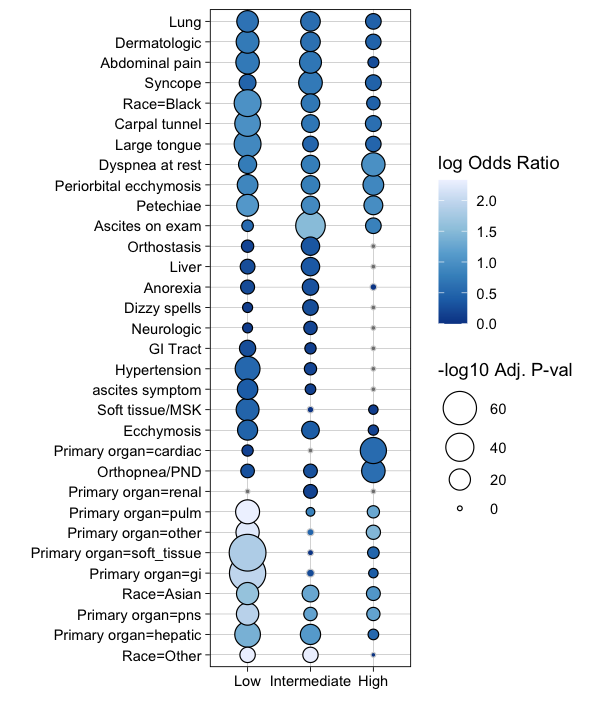

In [15]:
pdf("figures/mice_imputed_ccp_cluster_fe_enrichment.pdf", width=5, height=6) 
plotFisherExactEnrichment(contrasts.fe.df, h=6, w=5,)
dev.off()

In [12]:
pdf("figures/mice_imputed_ccp_cluster_enrichment.pdf", width=5, height=6) 
plotEnrichment(contrasts.df, h=6, w=5)
dev.off()

pdf 
  2

In [17]:
contrasts.df[contrasts.df$X=="24-hr UTP",]

,X,p_value,statistic,fdr_bh,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<ord>
9,24-hr UTP,1.181791e-39,-13.177542,3.676685e-39,High
31,24-hr UTP,2.240980e-148,25.941956,2.091581e-147,Intermediate
68,24-hr UTP,4.337602e-22,-9.662819,1.012107e-21,Low


In [20]:
contrasts.fe.df[contrasts.fe.df$feat=="Primary organ=renal",]

,X,feat,cluster,pval,pval_adj,odds_r
,<int>,<chr>,<ord>,<dbl>,<dbl>,<dbl>
27,26,Primary organ=renal,High,1.000000e+00,1.000000e+00,-0.9260197
70,69,Primary organ=renal,Intermediate,3.462588e-19,2.481522e-18,0.3103954
113,112,Primary organ=renal,Low,1.000000e+00,1.000000e+00,-0.2778198
